<a href="https://colab.research.google.com/github/Danishsiddiqui11/Model-for-image-classification-on-EuroSat-dataset/blob/main/ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importing necessary libraries 
from tensorflow import keras
import numpy as np
import pandas as pd
from keras.applications import resnet
from keras import models
from keras import layers
from keras import optimizers
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from keras.callbacks import ModelCheckpoint

In [3]:
# Load the ResNet50 model
resnet_model = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

94765736/94765736 [==============================] - 3s 0us/step


In [4]:
# checking the trainable status of the individual layers
for layer in resnet_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff1749ab5e0> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff0e4c4f070> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff0e4c4f580> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff0e44363d0> True
<keras.layers.core.activation.Activation object at 0x7ff0e4436af0> True
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7ff0e43f6b80> True
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7ff0e41482b0> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff0e40d17f0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff0e40d78b0> True
<keras.layers.core.activation.Activation object at 0x7ff0e40d7040> True
<keras.layers.convolutional.conv2d.Conv2D object at 0x7ff0e40d8400> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7ff0e40e8e80> True
<keras.layers.core.activati

In [5]:
# Adding classifier on top of Convolution model
# create model 
model = models.Sequential()

In [6]:
# Add the resnet50 convolutional model
model.add(resnet_model)

# Adding new Layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [7]:
# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 31,987,594
Trainable params: 31,934,474
Non-trainable params: 53,120
_________________________________________________________________


In [8]:
dataset_url = r'/content/drive/MyDrive/EuroSat/2750'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [10]:
# Fitting the CNN to the images(Image Augmentation, Image Preprocessing)
#from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
        rescale=1./255,
        shear_range=0.2,             
        zoom_range=0.2,              
        horizontal_flip=True,
         validation_split=0.2)

In [11]:
train_set = train_datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21624 images belonging to 10 classes.


In [12]:
#Normalizing the test set
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [13]:

# test_set = test_datagen.flow_from_directory(
#         'TestSet',
#         target_size=(64,64),
#         batch_size=32,
#         class_mode='categorical', 
#         shuffle=False)


In [14]:
test_set = test_datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=False,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5406 images belonging to 10 classes.


In [15]:
# setting the path to EuroSat Dataset
# path = 'E:\EuroSat\2750'
# os.chdir(path)

In [16]:
# lets dettermine dataset characteristics
print('Training Data: ',train_set[0][0].shape)
print('Test Data: ',test_set[0][0].shape)

Training Data:  (32, 64, 64, 3)
Test Data:  (32, 64, 64, 3)


In [17]:
# now shape of a single image
print('Shape of single image:', train_set[0][0][0].shape)

Shape of single image: (64, 64, 3)


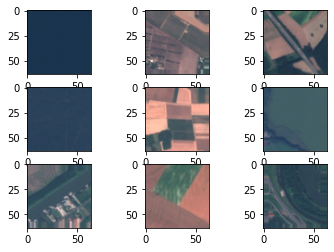

In [18]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = train_set[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

In [19]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
# checkpoint
filepath="/content/drive/MyDrive/weights/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# Train the model
history = model.fit(
          train_set, 
         steps_per_epoch=(train_set.samples/32),
         #steps_per_epoch=32,
          epochs=5,
          callbacks=callbacks_list,
          validation_data=test_set,
          validation_steps=(test_set.samples/32))
          #validation_steps=32)

Epoch 1/5
 71/675 [==>...........................] - ETA: 1:56:35 - loss: 0.7033 - acc: 0.8046

In [ ]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()